In [42]:
# Copyright (c) 2017-2019 Uber Technologies, Inc.
# SPDX-License-Identifier: Apache-2.0

import torch
from torch.distributions import constraints
from torch.nn import Parameter

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
from pyro.contrib.gp.models.model import GPModel
from pyro.contrib.gp.util import conditional
from pyro.distributions.util import eye_like
from pyro.nn.module import PyroParam, pyro_method



class VariationalGP(GPModel):
    r"""
    Variational Gaussian Process model.

    This model deals with both Gaussian and non-Gaussian likelihoods. Given inputs\
    :math:`X` and their noisy observations :math:`y`, the model takes the form

    .. math::
        f &\sim \mathcal{GP}(0, k(X, X)),\\
        y & \sim p(y) = p(y \mid f) p(f),

    where :math:`p(y \mid f)` is the likelihood.

    We will use a variational approach in this model by approximating :math:`q(f)` to
    the posterior :math:`p(f\mid y)`. Precisely, :math:`q(f)` will be a multivariate
    normal distribution with two parameters ``f_loc`` and ``f_scale_tril``, which will
    be learned during a variational inference process.

    .. note:: This model can be seen as a special version of
        :class:`.VariationalSparseGP` model with :math:`X_u = X`.

    .. note:: This model has :math:`\mathcal{O}(N^3)` complexity for training,
        :math:`\mathcal{O}(N^3)` complexity for testing. Here, :math:`N` is the number
        of train inputs. Size of variational parameters is :math:`\mathcal{O}(N^2)`.

    :param torch.Tensor X: A input data for training. Its first dimension is the number
        of data points.
    :param torch.Tensor y: An output data for training. Its last dimension is the
        number of data points.
    :param ~pyro.contrib.gp.kernels.kernel.Kernel kernel: A Pyro kernel object, which
        is the covariance function :math:`k`.
    :param ~pyro.contrib.gp.likelihoods.likelihood Likelihood likelihood: A likelihood
        object.
    :param callable mean_function: An optional mean function :math:`m` of this Gaussian
        process. By default, we use zero mean.
    :param torch.Size latent_shape: Shape for latent processes (`batch_shape` of
        :math:`q(f)`). By default, it equals to output batch shape ``y.shape[:-1]``.
        For the multi-class classification problems, ``latent_shape[-1]`` should
        corresponse to the number of classes.
    :param bool whiten: A flag to tell if variational parameters ``f_loc`` and
        ``f_scale_tril`` are transformed by the inverse of ``Lff``, where ``Lff`` is
        the lower triangular decomposition of :math:`kernel(X, X)`. Enable this flag
        will help optimization.
    :param float jitter: A small positive term which is added into the diagonal part of
        a covariance matrix to help stablize its Cholesky decomposition.
    """

    def __init__(
        self,
        X,
        y,
        kernel,
        likelihood,
        mean_function=None,
        latent_shape=None,
        whiten=False,
        jitter=1e-6,
    ):
        assert isinstance(
            X, torch.Tensor
        ), "X needs to be a torch Tensor instead of a {}".format(type(X))
        if y is not None:
            assert isinstance(
                y, torch.Tensor
            ), "y needs to be a torch Tensor instead of a {}".format(type(y))
        super().__init__(X, y, kernel, mean_function, jitter)

        self.likelihood = likelihood

        y_batch_shape = self.y.shape[:-1] if self.y is not None else torch.Size([])
        self.latent_shape = latent_shape if latent_shape is not None else y_batch_shape

        N = self.X.size(0)
        f_loc = self.X.new_zeros(self.latent_shape + (N,))
        self.f_loc = Parameter(f_loc)

        identity = eye_like(self.X, N)
        f_scale_tril = identity.repeat(self.latent_shape + (1, 1))
        self.f_scale_tril = PyroParam(f_scale_tril, constraints.lower_cholesky)

        self.whiten = whiten
        self._sample_latent = True

    @pyro_method
    def model(self):
        self.set_mode("model")

        N = self.X.size(0)
        Kff = self.kernel(self.X).contiguous()
        Kff.view(-1)[:: N + 1] += self.jitter  # add jitter to the diagonal
        Lff = torch.linalg.cholesky(Kff)

        zero_loc = self.X.new_zeros(self.f_loc.shape)
        if self.whiten:
            identity = eye_like(self.X, N)
            pyro.sample(
                self._pyro_get_fullname("f"),
                dist.MultivariateNormal(zero_loc, scale_tril=identity).to_event(
                    zero_loc.dim() - 1
                ),
            )
            f_scale_tril = Lff.matmul(self.f_scale_tril)
            f_loc = Lff.matmul(self.f_loc.unsqueeze(-1)).squeeze(-1)
        else:
            pyro.sample(
                self._pyro_get_fullname("f"),
                dist.MultivariateNormal(zero_loc, scale_tril=Lff).to_event(
                    zero_loc.dim() - 1
                ),
            )
            f_scale_tril = self.f_scale_tril
            f_loc = self.f_loc

        f_loc = f_loc + self.mean_function(self.X)
        f_var = f_scale_tril.pow(2).sum(dim=-1)
        if self.y is None:
            return f_loc, f_var
        else:
            return self.likelihood(f_loc, f_var, self.y)


    @pyro_method
    def guide(self):
        self.set_mode("guide")
        self._load_pyro_samples()

        pyro.sample(
            self._pyro_get_fullname("f"),
            dist.MultivariateNormal(self.f_loc, scale_tril=self.f_scale_tril).to_event(
                self.f_loc.dim() - 1
            ),
        )


    def forward(self, Xnew, full_cov=False):
        r"""
        Computes the mean and covariance matrix (or variance) of Gaussian Process
        posterior on a test input data :math:`X_{new}`:

        .. math:: p(f^* \mid X_{new}, X, y, k, f_{loc}, f_{scale\_tril})
            = \mathcal{N}(loc, cov).

        .. note:: Variational parameters ``f_loc``, ``f_scale_tril``, together with
            kernel's parameters have been learned from a training procedure (MCMC or
            SVI).

        :param torch.Tensor Xnew: A input data for testing. Note that
            ``Xnew.shape[1:]`` must be the same as ``self.X.shape[1:]``.
        :param bool full_cov: A flag to decide if we want to predict full covariance
            matrix or just variance.
        :returns: loc and covariance matrix (or variance) of :math:`p(f^*(X_{new}))`
        :rtype: tuple(torch.Tensor, torch.Tensor)
        """
        X_linear = Xnew[:, :1]
        X_gp = Xnew[:, 1:]

        # Linear part of one feature:
        linear_output = self.linear_layer(X_linear)

        self._check_Xnew_shape(X_gp)
        self.set_mode("guide")

        loc, cov = conditional(
            Xnew,
            self.X,
            self.kernel,
            self.f_loc,
            self.f_scale_tril,
            full_cov=full_cov,
            whiten=self.whiten,
            jitter=self.jitter,
        )
        return loc + self.mean_function(X_gp) + linear_output, cov

In [43]:
import numpy as np
from scipy.stats import norm, multivariate_normal
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib options
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

In [44]:
# Make data
# X, y = make_moons(n_samples=50, shuffle=True, noise=0.1, random_state=1)
from func import get_data

# Read data.
X_train,y_train,X_test,y_test,age = get_data()

# Prepare data for Pyro model
n_cat = int(y_train.max())

#print('n_ind', n_ind)
#X_train_tensor = torch.tensor(X_train.astype('float')).float()
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train).float()
X_test_tensor = torch.tensor(X_test, dtype=torch.float)
y_test_tensor = torch.tensor(y_test).float()
#print(y_train_tensor)


'''
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

print(X_train_tensor.shape)
print(y_train_tensor.shape)
'''


['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']


'\nprint(X_train.shape)\nprint(y_train.shape)\nprint(X_test.shape)\nprint(y_test.shape)\n\nprint(X_train_tensor.shape)\nprint(y_train_tensor.shape)\n'

In [47]:

# initialize the kernel, likelihood, and model
pyro.clear_param_store()
#kernel = gp.kernels.RBF(input_dim=13, lengthscale=torch.ones(13)) # 96.37% accuracy
kernel = gp.kernels.Matern32(input_dim=13, lengthscale=torch.ones(13)) # 99.01% accuracy

likelihood = gp.likelihoods.Binary()

# turn on "whiten" flag for more stable optimization
#vsgp = VariationalGP(X_train_tensor.reshape(-1, 13), y_train_tensor.reshape(-1), kernel, likelihood=likelihood, whiten=True, jitter=1e-6)
vsgp = VariationalGP(X_train_tensor, y_train_tensor, kernel, likelihood=likelihood, whiten=True, jitter=1e-6, latent_shape=torch.Size([]))

'''
model = gp.models.VariationalGP(
    X_train_tensor,
    y_train_tensor,
    kernel,
    likelihood=likelihood,
    whiten=True,
    jitter=1e-03,
    latent_shape=torch.Size([]),
)
'''

# instead of defining our own training loop, we will
# use the built-in support provided by the GP module
num_steps = 1500
losses = gp.util.train(vsgp, num_steps=num_steps)
#losses = gp.util.train(model, num_steps=num_steps)
#plt.plot(losses);
#jitter = 1e-6
#Lff = torch.cholesky(Kff + jitter * torch.eye(Kff.shape[0]))¨

plt.plot(losses)

_LinAlgError: linalg.cholesky: The factorization could not be completed because the input is not positive-definite (the leading minor of order 935 is not positive-definite).
     Trace Shapes:   
      Param Sites:   
kernel.lengthscale 13
   kernel.variance   
     Sample Sites:   

In [41]:
#mean, var = model(X_train_tensor)
#y_hat = model.likelihood(mean, var)

#print(f"Accuracy: {(y_hat==y_train_tensor).sum()*100/(len(y_train_tensor)) :0.2f}%")

mean, var = model(X_test_tensor)
y_hat = model.likelihood(mean, var)

print(f"Accuracy: {(y_hat==y_test_tensor).sum()*100/(len(y_test_tensor)) :0.2f}%")

Accuracy: 97.36%


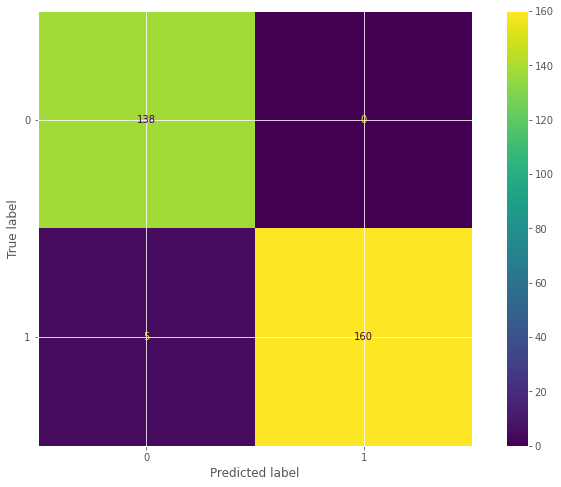

In [ ]:
#cm = confusion_matrix(y_train_tensor, y_hat, labels=[0, 1])
#ConfusionMatrixDisplay(cm).plot()

cm = confusion_matrix(y_test_tensor, y_hat, labels=[0, 1])
ConfusionMatrixDisplay(cm).plot()

In [ ]:
# Make predictions for test set
predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("obs", "_RETURN"))
samples = predictive(X)

AttributeError: 'AutoDiagonalNormal' object has no attribute 'loc'

In [ ]:
# Prepare test data for Pyro
X_test = torch.tensor(X_test).float()

guide = AutoDiagonalNormal(model)

In [ ]:
from pyro.infer import Predictive

# Get posterior samples for beta
predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("beta",))
samples = predictive(X_, y_test)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
Trace Shapes:
 Param Sites:
Sample Sites:
Trace Shapes:
 Param Sites:
Sample Sites: